In [55]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_union, make_pipeline, Pipeline
from sklearn.model_selection import ParameterGrid

from sklearn.impute import MissingIndicator, KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler

import plotly.express as px
import plotly.graph_objects as go

from fenginering.function import *
from fenginering.indicator import *
from fenginering.transformer import *
from fenginering.preprocessing import Crossover
from fenginering.preprocessing import Scale
from fenginering.get_data import *

import warnings

warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
SYMBOLS = ["BTC", "ETH", 'QNT', 'TWT', 'DASH']

asset = 'DASH'
start = "2017"
end = "2023"

data = get_data(asset, '1d').loc[start : end]
data.drop(columns = ['symbol'], inplace = True)
data.columns = data.columns.astype(str)
data.shape

(1542, 5)

In [57]:
def get_classification_target(data):
    data = data.copy()
    data['returns'] = data["close"].pct_change()
    data['target'] = data['returns'].rolling(3).mean().shift(-1)
    #data['target'] = data['returns'].shift(-1)
    data['target'] = np.where(data['target'] > 0, 1, 0)
    return data['target']


#data['target'] = get_classification_target(data)
#data = data.iloc[:-1]

In [58]:
data['returns'] = data.close.pct_change()
data.dropna(inplace=True)

data['target'] = data['returns'].rolling(3).mean()
data['target'] = data['target'].shift(-2)
data.dropna(inplace=True)

data['target'] = np.where(data['target'] > 0, 1, 0)

data.head()

,open,high,low,close,volume,returns,target
time,,,,,,,
2019-03-29,95.74,98.19,94.91,98.13,3565.30155,0.024963,1
2019-03-30,98.30,101.00,95.50,100.78,3540.27743,0.027005,1
2019-03-31,100.58,110.89,99.61,110.70,11668.43675,0.098432,1
2019-04-01,110.50,120.06,107.71,112.97,16508.93631,0.020506,1
2019-04-02,113.28,125.84,111.03,123.69,15379.30754,0.094892,1


<AxesSubplot: >

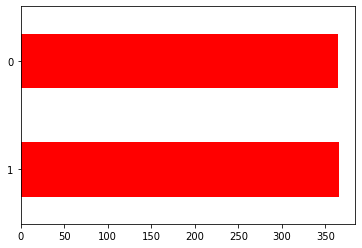

In [59]:
N = data.shape[0]
n = int(0.7*N)
train = data.loc["2021":"2022"]
test = data.loc["2023"]

features, target = train.drop(columns = ['target']), train['target']
features_test, target_test = test.drop(columns = ['target']), test['target']


target.value_counts().plot(kind = 'barh', color = 'red')

In [60]:
lag_ret_list = [1, 3, 5, 9, 15, 30]
ema_list = [3, 9, 15]
rsi_list = [10, 14, 20]


Indicators = MakeIndicator(features)

Indicators.set_stransformer(lag_returns, lag_ret_list)
Indicators.set_stransformer(rsi, rsi_list)


features = Indicators.transform()
date_range = features.index
target = target.loc[date_range]

In [61]:
# test

Indicators = MakeIndicator(features_test)

Indicators.set_stransformer(lag_returns, lag_ret_list)
Indicators.set_stransformer(rsi, rsi_list)

features_test = Indicators.transform()
date_range = features_test.index
target_test = target_test.loc[date_range]

# Model

In [62]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [63]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

model = RandomForestClassifier()
model.fit(features, target)


RandomForestClassifier()

In [64]:
#exp_cv = TimeSeriesSplit(n_splits = 10)
#cross_val_score(model, features, target, cv = exp_cv)

 Accuracy : 0.74 
 f1 : 0.70 
 precision : 0.69 
 recall : 0.70 
 AUC : 0.77 
              precision    recall  f1-score   support

           0       0.78      0.77      0.77        78
           1       0.69      0.70      0.70        57

    accuracy                           0.74       135
   macro avg       0.73      0.74      0.73       135
weighted avg       0.74      0.74      0.74       135



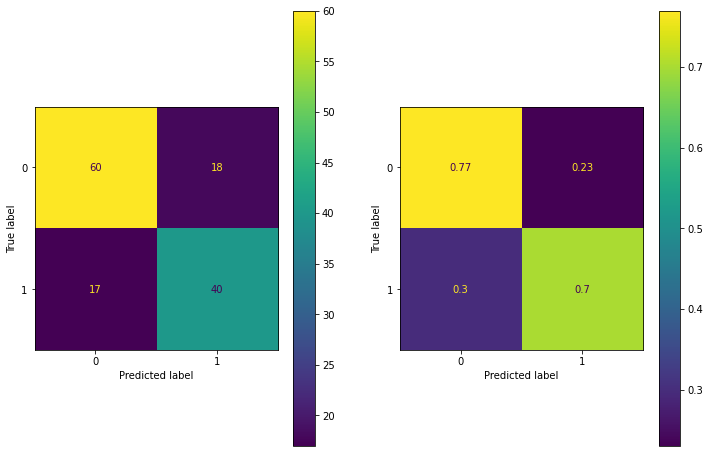

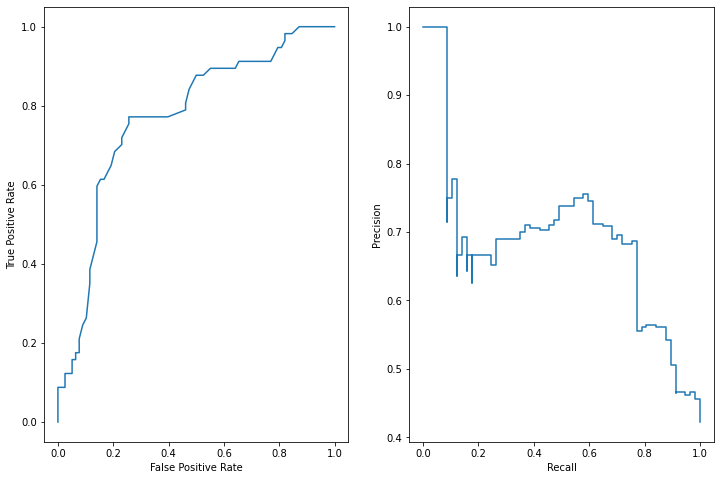

In [65]:
y_pred = model.predict(features_test)
y_pred_proba = model.predict_proba(features_test)

from evaluation.classification import *

evaluation = Evaluation(y_true = target_test, y_pred = y_pred, proba_pred = y_pred_proba[:,1])
evaluation.metrics()
evaluation.show()

In [66]:
from evaluation.curve import learningCurve

#learningCurve(model, X = features, y = target, cv = exp_cv, score = "accuracy")

In [67]:
import plotly.express as px

px.box(y_pred_proba[:,1])

In [68]:
import plotly.express as px

def Backtest(features_test, target_test):
    backtest = pd.DataFrame()
    #backtest['returns'] = features_test.close.pct_change()
    backtest['returns'] = features_test.ret_1_0
    backtest['target'] = target_test
    backtest['pred'] = y_pred
    
    backtest['pred_proba'] = y_pred_proba[:,1]
    
    backtest['signal'] = np.where(backtest['pred_proba'] > 0.6, 1,
                                  np.where(backtest['pred_proba'] <0.4, -1, 0)
                                  )

    backtest['cum_ret'] = (1 + backtest['returns']).cumprod()

    backtest['strategy'] = backtest['returns']*backtest['pred']
    backtest['strategy_cum_ret'] = (1 + backtest['strategy']).cumprod()
    
    backtest['strategy_2'] = backtest['returns']*backtest['signal']
    backtest['strategy_cum_ret_2'] = (1 + backtest['strategy_2']).cumprod()
    
    fig = px.line(backtest[['cum_ret', 'strategy_cum_ret', 'strategy_cum_ret_2']])
    fig.show()
    

In [69]:
Backtest(features_test, target_test)

In [70]:
features_test.shape

(135, 14)

In [71]:
import joblib

joblib.dump(model, f'model/model_{asset}.joblib')

['model/model_DASH.joblib']

In [72]:
m = joblib.load('model/model_1d.joblib')

x = features_test.iloc[-1].values.reshape([1, -1])

m.predict_proba(x)[:,1][0]

0.68